#### Create a Landmask with buffer

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import rasterio
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


In [ ]:
# -------------------------------
# User Parameters - Update these
# -------------------------------

# Path to your large OSM shoreline shapefile
input_shapefile = '/mnt/f/ArcticDeepSeepsData/shapefiles/osm/land-polygons-split-4326/land-polygons-split-4326/land_polygons.shp'
# input_shapefile = '/mnt/f/ArcticDeepSeepsData/shapefiles/osm/coastlines-split-4326/coastlines-split-4326/lines.shp'
# input_shapefile = '/mnt/f/ArcticDeepSeepsData/shapefiles/GSHHS/GSHHS_shp/f/GSHHS_f_L1.shp'



# Coordinate Reference System (CRS) of your shapefile
shapefile_crs = 'EPSG:4326'  # or 'EPSG:3857'

# Define your Area of Interest (AOI) using a WKT polygon
# aoi_wkt = "POLYGON((-55.64 67.27,-51.95 67.27,-51.95 69.23,-55.64 69.23,-55.64 67.27))"

aoi_wkt = "POLYGON((-71.495 71.0, -68.7 71.0, -68.7 72, -71.495 72, -71.495 71.0))" # scott trough area


# CRS of the GeoTIFF files
geotiff_crs = 'EPSG:32633'  # UTM Zone 33N
# geotiff_crs = 'EPSG:32619'  # UTM Zone 19N
# geotiff_crs = 'EPSG:32621'  # UTM Zone 21N


# Pixel size in meters: adjust based on your GeoTIFF resolution
pixel_size = 40 
# Desired buffer size in number of pixels
buffer_pixels = 5

# Create folder for output shapefile
og_shapefilename = input_shapefile.split('/')[-1].split('.')[0]
filename_new = f'{og_shapefilename}_buffered_{pixel_size}m_{buffer_pixels}px'
output_dir = f'/mnt/f/ArcticDeepSeepsData/temp/{filename_new}/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path where the smaller buffered shapefile will be saved using the buffer_pixels variable in .shp file name
output_shapefile = f'/mnt/f/ArcticDeepSeepsData/temp/{filename_new}/{filename_new}.shp'



In [3]:
# -------------------------------
# Shapefile Generation Code
# -------------------------------

def directional_buffer(geom, dist):
    """
    - If this is a LineString / MultiLineString: do a single-sided buffer
      (you get a Polygon strip on one side).
    - If this is a Polygon / MultiPolygon: do a normal buffer (expands outward).
    """
    t = geom.geom_type
    if t in ("LineString", "MultiLineString"):
        # single_sided=True only makes sense on linear geometries
        return geom.buffer(dist, single_sided=True)
    elif t in ("Polygon", "MultiPolygon"):
        # standard outward buffer on a polygon
        return geom.buffer(dist)
    else:
        # catch–all: just do a normal buffer
        return geom.buffer(dist)


# Calculate buffer distance in meters
buffer_distance = pixel_size * buffer_pixels
print(f"Buffer distance: {buffer_distance} meters")

# Create a GeoDataFrame for the AOI from the WKT polygon
aoi_geometry = wkt.loads(aoi_wkt)
aoi = gpd.GeoDataFrame({'geometry': [aoi_geometry]}, crs=shapefile_crs)

# Reproject AOI to the shapefile's CRS if necessary
if aoi.crs != shapefile_crs:
    print(f"Reprojecting AOI from {aoi.crs} to {shapefile_crs}...")
    aoi = aoi.to_crs(shapefile_crs)

print("Loading the large OSM shoreline shapefile...")
# Read the large OSM shoreline shapefile
gdf = gpd.read_file(input_shapefile)

# Ensure the CRS matches; reproject if necessary
if gdf.crs != shapefile_crs:
    print(f"Reprojecting shapefile from {gdf.crs} to {shapefile_crs}...")
    gdf = gdf.to_crs(shapefile_crs)

print("Clipping the shoreline shapefile to the AOI...")
# Clip the shoreline shapefile to the AOI
gdf_clipped = gpd.clip(gdf, aoi)

# Reproject the clipped shapefile to GeoTIFF CRS for buffering
if gdf_clipped.crs != geotiff_crs:
    print(f"Reprojecting clipped shapefile from {gdf_clipped.crs} to {geotiff_crs} for buffering...")
    gdf_clipped_proj = gdf_clipped.to_crs(geotiff_crs)
else:
    gdf_clipped_proj = gdf_clipped



print(f"Applying a buffer of {buffer_distance} meters to the shoreline geometries...")
gdf_clipped_proj = gdf_clipped.to_crs(geotiff_crs)

# apply our universal buffer:
gdf_buffered_proj = gdf_clipped_proj.copy()
gdf_buffered_proj["geometry"] = (
    gdf_clipped_proj.geometry
    .apply(lambda g: directional_buffer(g, buffer_distance))
)
gdf_buffered = gdf_buffered_proj.to_crs(shapefile_crs)



print(f"Saving the smaller buffered shapefile to {output_shapefile}...")
# Save the result to a new shapefile
gdf_buffered.to_file(output_shapefile)

print("Shapefile generation complete!")

Buffer distance: 200 meters
Loading the large OSM shoreline shapefile...
Clipping the shoreline shapefile to the AOI...
Reprojecting clipped shapefile from EPSG:4326 to EPSG:32633 for buffering...
Applying a buffer of 200 meters to the shoreline geometries...
Saving the smaller buffered shapefile to /mnt/f/ArcticDeepSeepsData/temp/land_polygons_buffered_40m_5px/land_polygons_buffered_40m_5px.shp...
Shapefile generation complete!


In [4]:
# output_shapefile = f'/mnt/f/ArcticDeepSeepsData/temp/scott_coastlines_{buffer_pixels}px.shp'

Loading the buffered shoreline shapefile...
Loading the original shoreline shapefile...
Clipping the original shoreline shapefile to the AOI...
Creating the plot...


/tmp/ipykernel_980640/3702418780.py:86: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles=[aoi_handle, original_handle, buffer_handle],


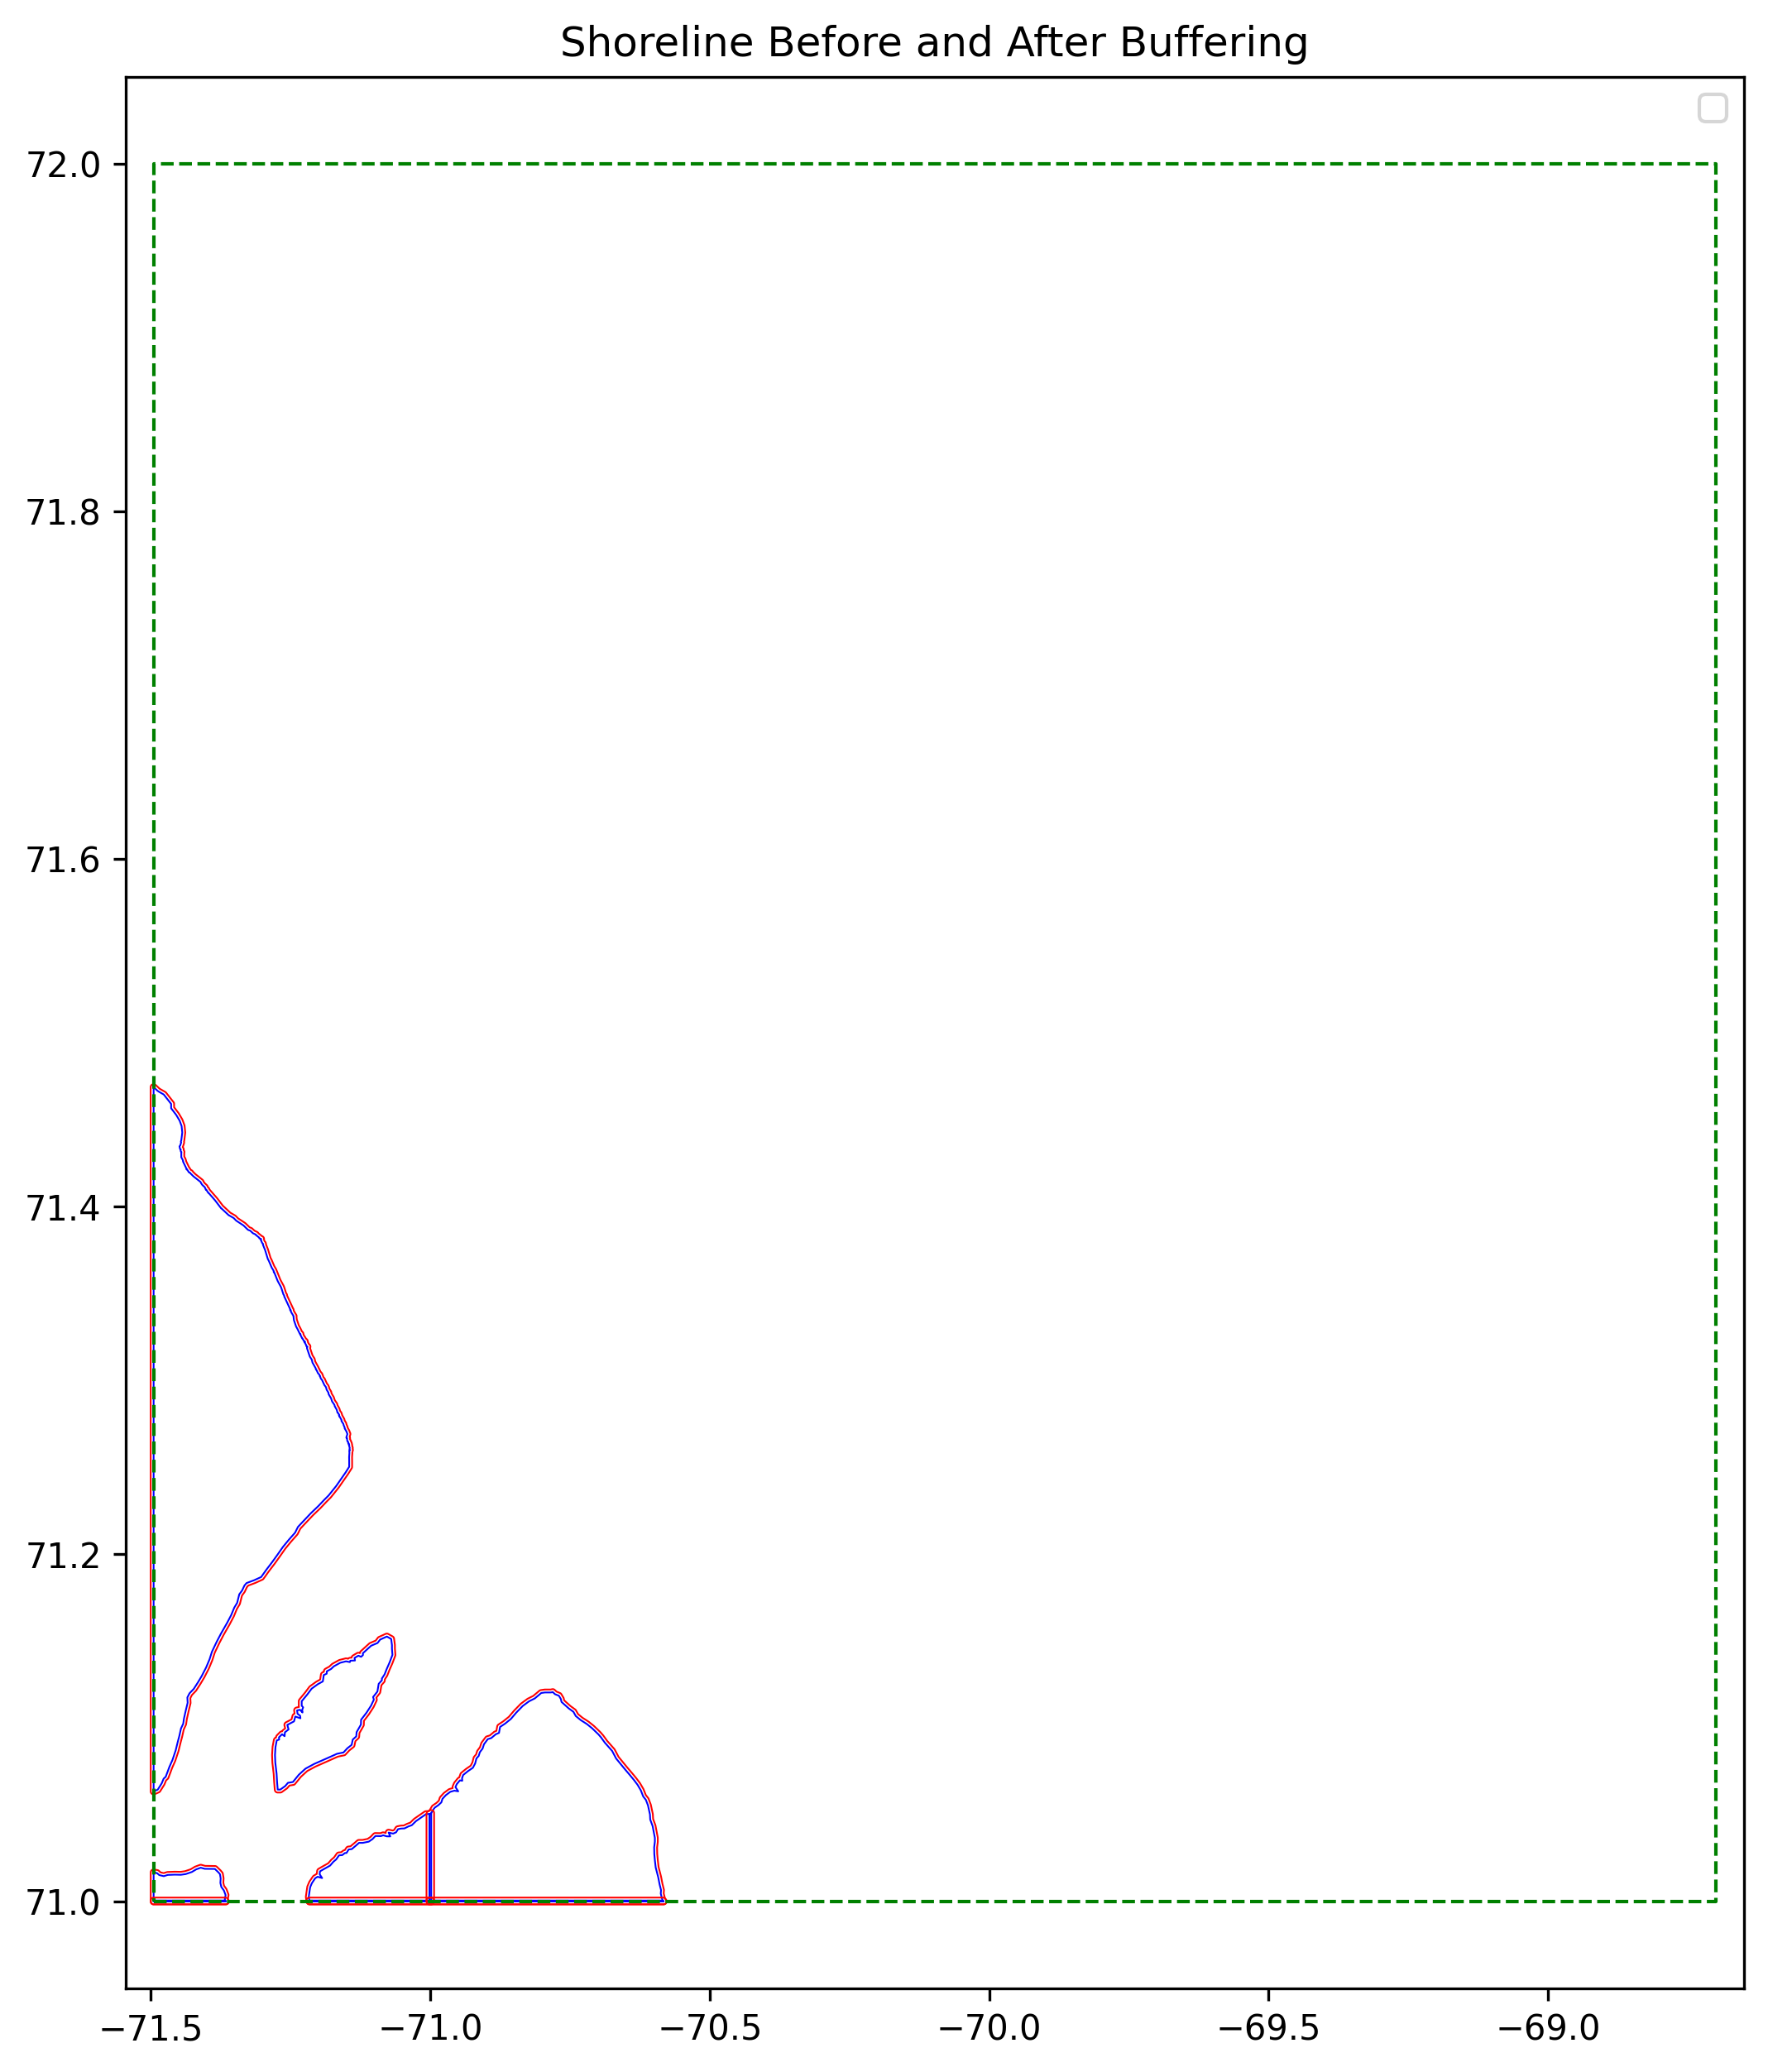

In [5]:
# -------------------------------
# Plotting Code
# -------------------------------

# Create a GeoDataFrame for the AOI from the WKT polygon
aoi_geometry = wkt.loads(aoi_wkt)
aoi = gpd.GeoDataFrame({'geometry': [aoi_geometry]}, crs=shapefile_crs)

# Load the buffered shoreline shapefile generated in Cell 1
print("Loading the buffered shoreline shapefile...")
gdf_buffered = gpd.read_file(output_shapefile)

# Load the original shoreline shapefile
print("Loading the original shoreline shapefile...")
gdf_original = gpd.read_file(input_shapefile)

# Ensure the CRS matches; reproject if necessary
if gdf_original.crs != shapefile_crs:
    print(f"Reprojecting original shapefile from {gdf_original.crs} to {shapefile_crs}...")
    gdf_original = gdf_original.to_crs(shapefile_crs)

if gdf_buffered.crs != shapefile_crs:
    print(f"Reprojecting buffered shapefile from {gdf_buffered.crs} to {shapefile_crs}...")
    gdf_buffered = gdf_buffered.to_crs(shapefile_crs)

# Clip the original shoreline shapefile to the AOI
print("Clipping the original shoreline shapefile to the AOI...")
gdf_original_clipped = gpd.clip(gdf_original, aoi)

# Create the plot
print("Creating the plot...")
fig, ax = plt.subplots(figsize=(10,10), dpi=300)

# 1) AOI box
aoi_handle = aoi.boundary.plot(
    ax=ax,
    color='green',
    linestyle='--',
    linewidth=1,
    label='AOI Boundary'
)

# 2) Original lines
original_handle = gdf_original_clipped.plot(
    ax=ax,
    linewidth=0.5,
    facecolor='none',
    edgecolor='blue',
    label='Original Shoreline'
)

# # 3) Buffered outline (choose one)
# # Option A: exterior ring only
# buffer_exterior = gpd.GeoSeries(
#     [poly.exterior for poly in gdf_buffered.geometry],
#     crs=gdf_buffered.crs
# )
# buffer_exterior.plot(
#     ax=ax,
#     color='red',
#     linewidth=0.5,
#     linestyle='--',
#     label='Buffered Shoreline (outline only)'
# )

# Option B: plot the polygons with no fill
buffer_handle = gdf_buffered.plot(
    ax=ax,
    facecolor='none',
    edgecolor='red',
    linewidth=0.5,
    label='Buffered Shoreline polygons'
)

# xlim and ylim based on AOI
lat_margin = 0.05  # Adjust as needed
lon_margin = 0.05  # Adjust as needed

ax.set_xlim(aoi.bounds.minx.min() - lon_margin, aoi.bounds.maxx.max() + lon_margin)
ax.set_ylim(aoi.bounds.miny.min() - lat_margin, aoi.bounds.maxy.max() + lat_margin)


ax.set_title('Shoreline Before and After Buffering')


ax.legend(handles=[aoi_handle, original_handle, buffer_handle],
          loc='upper right')

# Save the plot if needed
# plt.savefig(f'{output_dir}/shoreline_buffer_comparison.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


Print shapefile data

In [ ]:
import geopandas as gpd

# shapefile_path = "utm_zones.shp"
shapefile_path = "/home/mtontsch/Nextcloud/data_nextcloud/shapefiles/osm_scott_buffered/ScottTrough_5px.shp"
# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the first few rows of the GeoDataFrame
print("First few rows of the GeoDataFrame:")
print(gdf.head())

# Print the column names
print("\nColumn names:")
print(gdf.columns)

# Print the CRS (Coordinate Reference System)
print("\nCoordinate Reference System (CRS):")
print(gdf.crs)

# Print the total number of features
print("\nTotal number of features:")
print(len(gdf))

# Print the geometry type of the features
print("\nGeometry type of the features:")
print(gdf.geom_type.unique())

# Print summary statistics of the numerical columns
print("\nSummary statistics of the numerical columns:")
print(gdf.describe())

# Print the bounds of the geometries
print("\nBounds of the geometries:")
print(gdf.total_bounds)